In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GQLEQELAALDQQIAALKQRRAALKWQIQG', 'GQLEQELAALDQQIAALKQRRAALKWQIQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['c'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 5.0, 200, 205.6, 10]


Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std  	min     	max     
0  	77   	-831.442	19.75	-893.162	-800.431
1  	85   	-846.963	16.5368	-895.751	-823.947
2  	68   	-853.622	14.8481	-903.001	-833.047
3  	75   	-859.71 	13.2936	-903.001	-842.359
4  	59   	-866.575	14.361 	-909.963	-846.349
5  	58   	-873.281	15.7896	-910.167	-849.953
6  	59   	-884.669	15.8684	-923.565	-860.73 
7  	74   	-899.423	9.33985	-923.565	-880.81 
8  	66   	-905.932	7.53559	-923.565	-892.959
9  	65   	-911.176	4.52891	-923.565	-901.937
10 	55   	-914.429	3.58935	-926.433	-909.228
11 	78   	-917.157	3.15208	-926.803	-912.798
12 	78   	-919.372	3.10049	-926.88 	-915.645
13 	66   	-921.944	2.97812	-927.147	-917.657
14 	49   	-923.891	2.4227 	-927.483	-919.6  
15 	69   	-925.504	1.65124	-927.483	-921.652
16 	63   	-926.535	0.675726	-927.504	-924.505
17 	71   	-926.999	0.262903	-927.55 	-926.521
18 	84   	-927.23 	0.231271	-927.573	-926.865
19 	70   	-927.416	0.126757	-927.582	-927.064
20 	78   	-927.494	0.0460539	-927.605	-927.407
21 	73  

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-927.6961407764732

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

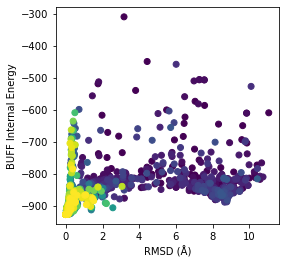

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('d_apCC-Di_new-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-828.232	26.1681	-912.007	-735.723
1  	100  	-841.054	22.9417	-912.007	-755.412
2  	100  	-850.474	19.1867	-912.007	-806.366
3  	100  	-855.138	19.0848	-912.007	-816.882
4  	100  	-859.883	18.1303	-912.007	-828.501
5  	100  	-865.908	19.4228	-913.032	-828.501
6  	100  	-870.232	18.1191	-913.032	-829.545
7  	100  	-877.184	18.916 	-915.216	-836.914
8  	100  	-882.632	18.0663	-923.751	-836.914
9  	100  	-887.056	16.7414	-923.751	-845.782
10 	100  	-889.912	15.9647	-923.751	-845.782
11 	100  	-894.078	15.1461	-923.751	-860.939
12 	100  	-897.911	14.0574	-923.751	-861.421
13 	100  	-900.397	12.8028	-923.751	-865.247
14 	100  	-903.055	11.1123	-923.751	-865.247
15 	100  	-905.809	10.2605	-925.511	-870.745
16 	100  	-907.693	8.84767	-925.511	-880.604
17 	100  	-910.255	8.52904	-925.511	-884.221
18 	100  	-911.079	8.15527	-925.511	-884.221
19 	100  	-912.634	7.28629	-925.511	-892.801
20 	100  	-913.732	6.92336	-925.511	-896.128
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-929.9471562371295

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

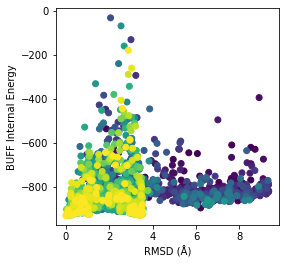

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('d_apCC-Di_new-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-781.645	121.242	-905.565	109.781
1  	93   	-768.484	162.126	-906.094	109.781
2  	84   	-727.657	184.365	-902.661	109.781
3  	82   	-786.202	116.063	-878.492	-15.6782
4  	91   	-764.093	129.541	-903.218	-79.5817
5  	96   	-773.073	126.892	-911.601	-79.5817
6  	80   	-776.795	115.121	-905.417	-162.091
7  	70   	-800.045	86.6948	-914.807	-317.495
8  	87   	-799.318	87.7793	-912.677	-239.672
9  	82   	-770.008	138.892	-907.617	-12.1703
10 	90   	-778.758	135.305	-903.444	25.6496 
11 	88   	-799.689	115.07 	-895.956	25.6496 
12 	93   	-826.801	46.7809	-914.922	-573.346
13 	83   	-796.095	110.415	-918.015	-324.106
14 	65   	-738.501	158.578	-910.148	-163.957
15 	78   	-718.748	218.678	-913.542	355.002 
16 	72   	-788.536	173.786	-913.542	355.002 
17 	72   	-820.765	43.3581	-910.148	-635.243
18 	76   	-748.373	156.265	-910.149	58.041  
19 	81   	-780.482	119.399	-899.282	-217.034
20 	87   	-812.842	46.7035	-889.131	-575.456
21 	94   	-820

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-918.0152005994086

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

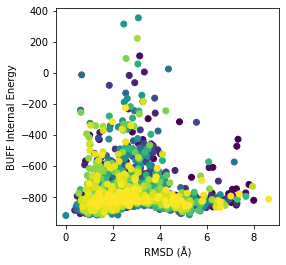

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('d_apCC-Di_new-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max     
0  	100  	-803.98	48.1076	-884.343	-596.397
1  	100  	-807.257	43.2196	-883.986	-638.678
2  	100  	-819.649	35.0713	-893.105	-673.803
3  	100  	-820.211	42.7586	-901.033	-547.065
4  	100  	-811.893	56.2803	-898.009	-386.801
5  	100  	-817.275	37.0808	-886.948	-706.19 
6  	100  	-821.751	39.0727	-904.705	-726.229
7  	100  	-814.663	44.1142	-900.758	-697.05 
8  	100  	-816.353	39.8916	-894.762	-714.975
9  	100  	-821.802	43.5085	-895.745	-712.245
10 	100  	-830.814	45.9495	-905.281	-709.13 
11 	100  	-817.57 	50.2414	-902.433	-601.864
12 	100  	-822.845	46.8944	-905.527	-716.311
13 	100  	-824.114	46.7067	-902.735	-699.894
14 	100  	-827.335	48.0733	-904.769	-715.715
15 	100  	-831.307	46.6914	-904.371	-704.876
16 	100  	-836.072	59.6887	-908.742	-630.003
17 	100  	-859.509	44.3384	-910.015	-691.186
18 	100  	-872.313	35.3614	-911.354	-762.443
19 	100  	-894.455	18.717 	-918.535	-813.958
20 	100  	-898.222	14.7397	-916.591	-850.188
21 	100  	-9

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-922.5789025723091

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

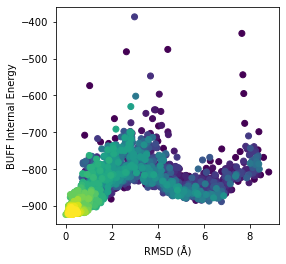

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('d_apCC-Di_new-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)